In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# 각각 경로 지정
normal = "/content/drive/MyDrive/Datasets/Car_Images_train/normal/"
abnormal = "/content/drive/MyDrive/Datasets/Car_Images_train/abnormal/"
mainpath = "/content/drive/MyDrive/Datasets/Car_Images_train/"

## 2.데이터 전처리

## 3.모델링 I
* **세부요구사항**
    * 모델링을 위한 데이터 구조 만들기
        * x : 이미지를 array로 변환합니다.
        * y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

### (1) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다. 
    * 이미지 파일을 불러와 train, valid, test 각각 array 형태로 변환해 봅시다.
        * 각 폴더로 부터 이미지 목록을 만들고
        * 이미지 한장씩 적절한 크기로 로딩하여 (keras.utils.load_img)
            * 이미지가 너무 크면 학습시간이 많이 걸리고, 메모리 부족현상이 발생될 수 있습니다.
            * 이미지 크기를 280 * 280 * 3 이내의 크기를 설정하여 로딩하시오.
            * array로 변환 (keras.utils.img_to_array, np.expand_dims)
        * 데이터셋에 추가합니다.(데이터셋도 array)

#### 1) 이미지 목록 만들기
* train, validation, test 폴더로 부터 이미지 목록을 생성합니다.

In [5]:
modelpath = mainpath + "model_data/"
modelpath

'/content/drive/MyDrive/Datasets/Car_Images_train/model_data/'

In [6]:
train_list = [] 
val_list = []
test_list = []

In [7]:
# 이미지 목록 저장
temp_train_list = os.listdir(modelpath + "train/allcopy/")
temp_val_list = os.listdir(modelpath + "val/allcopy/")
temp_test_list = os.listdir(modelpath + "test/allcopy/")


for i in temp_train_list:
    train_list.append(modelpath + "train/allcopy/" + i)
for i in temp_val_list:
    val_list.append(modelpath + "val/allcopy/" + i)
for i in temp_test_list:
    test_list.append(modelpath + "test/allcopy/" + i)

train_list[:5]

['/content/drive/MyDrive/Datasets/Car_Images_train/model_data/train/allcopy/DALL·E 2023-03-10 18.52.44 - photo of a part of car.png',
 '/content/drive/MyDrive/Datasets/Car_Images_train/model_data/train/allcopy/DALL·E 2023-03-10 18.50.29 - photo of a part of car.png',
 '/content/drive/MyDrive/Datasets/Car_Images_train/model_data/train/allcopy/DALL·E 2023-03-10 18.52.17 - photo of a part of car.png',
 '/content/drive/MyDrive/Datasets/Car_Images_train/model_data/train/allcopy/DALL·E 2023-03-10 18.52.40 - photo of a part of car.png',
 '/content/drive/MyDrive/Datasets/Car_Images_train/model_data/train/allcopy/DALL·E 2023-03-10 22.07.07 - photo of a part of car.png']

In [8]:
# 메모리, 처리시간을 위해서 이미지 크기 조정
img_size = 80 ## 사이즈 조정 가능

#### 2) 이미지들을 배열 데이터셋으로 만들기

In [9]:
from PIL import Image

# train 데이터 배열 데이터셋화

train = []
for i in train_list:
    img = Image.open(i)
    img = img.resize((img_size, img_size))
    train.append(np.array(img))
train = np.array(train)
train.shape

(387, 80, 80, 3)

In [10]:
# val 데이터 배열 데이터셋화

val = []
for i in val_list:
    img = Image.open(i)
    img = img.resize((img_size, img_size))
    val.append(np.array(img))
val = np.array(val)
val.shape

(96, 80, 80, 3)

In [11]:
# test 데이터 배열 데이터셋화

test = []
for i in test_list:
    img = Image.open(i)
    img = img.resize((img_size, img_size))
    test.append(np.array(img))
test = np.array(test)
test.shape

(122, 80, 80, 3)

- img_path = tr_path + img

### (2) y : 클래스 만들기
- **세부요구사항**
    - Training set / Validation set / Test set의 y를 생성합니다.
        - 각각 normal, abnormal 데이터의 갯수를 다시 확인하고
        - normal을 0, abnormal을 1로 지정합니다.

In [12]:
# 데이터 갯수 확인
print( len(temp_train_list) )
print( len([val for val in temp_train_list if val.startswith('ab_')]) )
print('---')
print( len(temp_val_list) )
print( len([val for val in temp_val_list if val.startswith('ab_')]) )
print('---')
print( len(temp_test_list) )
print( len([val for val in temp_test_list if val.startswith('ab_')]) )

387
195
---
96
52
---
122
56


* y_train, y_valid, y_test 만들기
    * normal, abnormal 데이터의 갯수를 다시 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [13]:
train_label = np.array([1 if i.startswith('ab_') else 0 for i in temp_train_list ])
val_label = np.array([1 if i.startswith('ab_') else 0 for i in temp_val_list ])
test_label = np.array([1 if i.startswith('ab_') else 0 for i in temp_test_list ])

len(train_label), len(val_label), len(test_label)

(387, 96, 122)

In [14]:
x_train = train.copy()
x_val = val.copy()
x_test = test.copy()

y_train = train_label.copy()
y_val = val_label.copy()
y_test = test_label.copy()

In [15]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((387, 80, 80, 3), (96, 80, 80, 3), (122, 80, 80, 3), (387,), (96,), (122,))

In [16]:
from tensorflow.keras.utils import to_categorical

class_n = len(np.unique(y_train))

y_train_ss = to_categorical(y_train, class_n)
y_val_ss = to_categorical(y_val, class_n)
y_test_ss = to_categorical(y_test, class_n)

y_train_ss.shape

(387, 2)

### x 표준화

In [17]:
x_train.shape

(387, 80, 80, 3)

In [18]:
mean_v, std_v = x_train.mean(), x_train.std()
x_train_ss = (x_train - mean_v) / std_v
x_val_ss = (x_val - mean_v) / std_v
x_test_ss = (x_test - mean_v) / std_v

x_train_ss.mean(), x_train_ss.std()

(5.021727124475923e-17, 1.0)

In [19]:
x_train_ss.shape, y_train.shape

((387, 80, 80, 3), (387,))

### (2) Transfer Learning
- **세부요구사항**
    * VGG16 모델은 1000개의 클래스를 분류하는 데 사용된 ImageNet 데이터셋을 기반으로 사전 학습된 가중치를 가지고 있습니다. 
        * 따라서 이 모델은 이미지 분류 문제에 대한 높은 성능을 보입니다.
        * 이 모델은 보통 전이학습(transfer learning)에서 기본적으로 사용되며, 특히 대규모 데이터셋이 없을 때는 기본 모델로 사용되어 fine-tuning을 수행합니다.
    * VGG16 함수로 부터 base_model 저장


In [20]:
from tensorflow.keras.applications import VGG16

#### 1) VGG16 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 True로 설정하여 모델의 모든 레이어들이 fine-tuning에 대해 업데이트되도록 합니다.


In [21]:
x_train.shape

(387, 80, 80, 3)

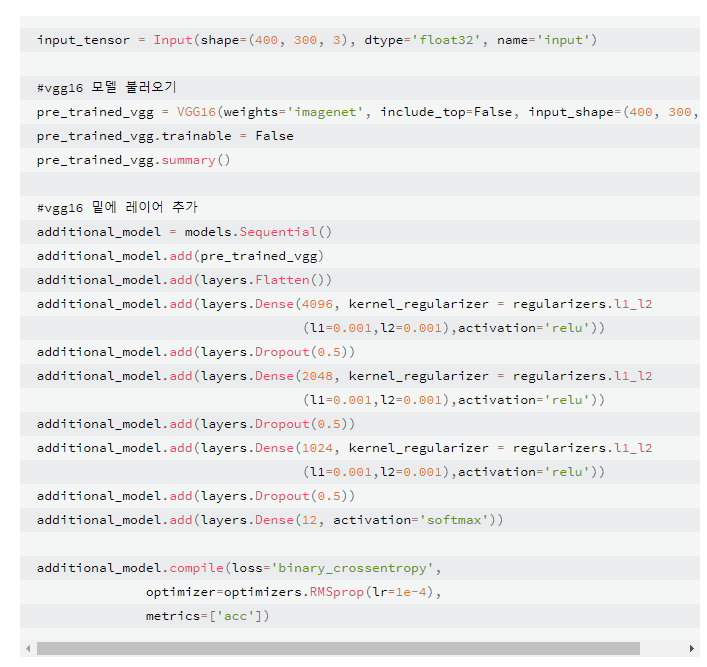

#### 2) VGG16과 연결한 구조 설계
* VGG16을 불러와서 Flatten, Dense 등으로 레이어 연결하기

In [22]:
clear_session()
base_model = VGG16(include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_size, img_size, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax")
base_model.trainable = True
new_model = keras.models.Sequential()
new_model.add(base_model)
new_model.add(keras.layers.Flatten())
new_model.add(keras.layers.Dropout(0.2))
new_model.add(keras.layers.Dense(2, activation='sigmoid'))
new_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 14,718,786
Trainable params: 14,718,786
Non-trainable params: 0
_________________________________________________________________


In [28]:
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', patience=100,
                             verbose=1, save_best_only=True, save_weights_only=False, 
                             mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                      patience=100, verbose=1, mode='auto')
vgg = new_model.fit(x_train, y_train_ss,
                           validation_data= (x_val, y_val_ss), validation_steps=10,
                           epochs=2000,callbacks=[checkpoint, early])

Epoch 1/2000
12/13 [==========================>...] - ETA: 0s - loss: 6.2783e-06 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.84375, saving model to vgg16_1.h5
13/13 [==============================] - 2s 121ms/step - loss: 6.2296e-06 - accuracy: 1.0000 - val_loss: 5.8708 - val_accuracy: 0.8438
Epoch 2/2000
12/13 [==========================>...] - ETA: 0s - loss: 1.0978e-06 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.84375
13/13 [==============================] - 1s 79ms/step - loss: 1.0893e-06 - accuracy: 1.0000 - val_loss: 5.9729 - val_accuracy: 0.8333
Epoch 3/2000
12/13 [==========================>...] - ETA: 0s - loss: 1.2385e-07 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.84375
13/13 [==============================] - 1s 79ms/step - loss: 1.2289e-07 - accuracy: 1.0000 - val_loss: 6.0090 - val_accuracy: 0.8333
Epoch 4/2000
12/13 [==========================>...] - ETA: 0s - loss: 9.8955e-08 - accuracy: 1.0000
Epoch 4: val_ac

In [29]:
y_pred = new_model.predict(x_test)
y_pred_s = y_pred.argmax(axis=1)
y_pred_s.shape, y_pred_s[:30]

4/4 [==============================] - 1s 219ms/step


((122,),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0]))

In [30]:
# confusion matrix, accuracy, recall, precision, f1 score
from sklearn.metrics import *

print("confusion_matrix: \n", confusion_matrix(y_test, y_pred_s))
print("accuracy_score:", accuracy_score(y_test, y_pred_s))
print("recall_score:", recall_score(y_test, y_pred_s))
print("precision_score:", precision_score(y_test, y_pred_s))
print("f1_score:", f1_score(y_test, y_pred_s))

confusion_matrix: 
 [[57  9]
 [ 3 53]]
accuracy_score: 0.9016393442622951
recall_score: 0.9464285714285714
precision_score: 0.8548387096774194
f1_score: 0.8983050847457628


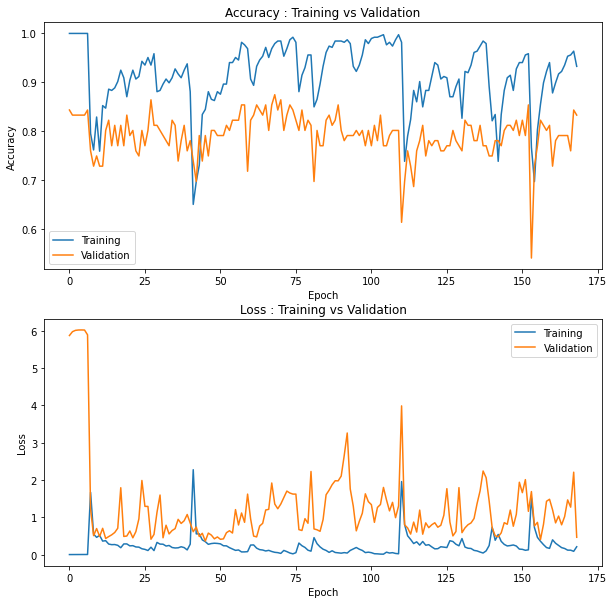

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.plot(vgg.history['accuracy'])
plt.plot(vgg.history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)

plt.subplot(212)
plt.plot(vgg.history['loss'])
plt.plot(vgg.history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

id = 80
모델의 카테고리별 확률 : 
{'normal': 0.0, 'abnormal': 99.0}


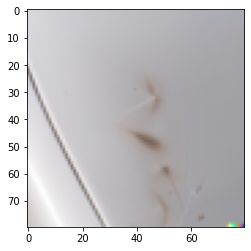

In [32]:
'''
성능 확인을 위해
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''
import random as rd
import matplotlib.pyplot as plt


labels = {0: "normal", 1: "abnormal"}
id = rd.randrange(0,121)

print(f'id = {id}')

prob = np.floor(y_pred[id]*100).tolist()
prob_dict = {}

for idx, prob in enumerate(prob) :
    prob_dict[ labels[idx] ] = prob

print('모델의 카테고리별 확률 : ')
print(prob_dict)


plt.imshow(x_test[id])
plt.show()

#### 3) 학습
- **세부요구사항**
    - 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
    - 데이터
        * Image Generator를 연결하거나
        * 기존 train, validation 셋을 이용해도 됩니다.
        - Early Stopping을 반드시 사용하세요.
        - 최적의 가중치를 모델에 적용하세요.